In [1]:
### Look at possibly mesotidal (between 2-4 m tidal ranges) off the coast of South Carolina. 
# 2023 SD-1045 spent a few months onshore of 50 m isobath off the coast of SC. 
# This could be a good case to show for the need to remove tidal currents from SD ADCP data
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pyfes ### has to use newpycode
import os
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)

In [41]:
### SD-1042 merged nc file info
year = '2023'
platf_num = '1045'
path_adcp = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'

### load adcp data
ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_adcp.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
lon = ds_adcp.variables['longitude'][:]
lat = ds_adcp.variables['latitude'][:]
uCur_SD = ds_adcp.variables['vel_east'][:]*100 # cm/s
vCur_SD = ds_adcp.variables['vel_north'][:]*100
error_vel = ds_adcp.variables['error_vel'][:]*100
vel_up = ds_adcp.variables['vel_up'][:]*100
echo_intensity = ds_adcp.variables['echo_intensity'][:]
depths_cur_SD = ds_adcp.variables['depth'][:] # the shallowest depth should be ~6m. 
depths_cur_SD = depths_cur_SD+1.8
print('Depths of SD:',depths_cur_SD)
print(echo_intensity.shape)

Depths of SD: [  6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.  32.
  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.
  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.
  90.  92.  94.  96.  98. 100. 102. 104.]
(28325, 4, 50)


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_19026/1773577135.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  time = ds_adcp.variables['time'][:]
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_19026/1773577135.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = ds_adcp.variables['longitude'][:]
/var/folders/kq/v

In [16]:
### Use pyfes tool box to build the tide model
path_aviso = os.path.expanduser('~/Documents/Data/AVISO/auxiliary/tide_model/fes2014/')
ConfigFileU = path_aviso+'eastward_velocity.ini'
ConfigFileV = path_aviso+'/northward_velocity.ini'
eastward_velocity = pyfes.Handler("ocean","memory",ConfigFileU)
northward_velocity = pyfes.Handler("ocean", "memory",ConfigFileV)

In [43]:
### get tidal currents by specifying time and locations
u_tide = np.nan*np.ones( len(dtime_cur_SD) )
v_tide = u_tide.copy()
for i in range( len(dtime_cur_SD) ):
    u_tide[i], _, _ = eastward_velocity.calculate(np.array([lon[i]]),np.array([lat[i]]),np.array([dtime_cur_SD[i]]))
    v_tide[i], _, _ = northward_velocity.calculate(np.array([lon[i]]),np.array([lat[i]]),np.array([dtime_cur_SD[i]]))

### de-tide
uCur_SD_detide = np.nan*np.ones( uCur_SD.shape )
vCur_SD_detide = uCur_SD_detide.copy()
for z in range( len(depths_cur_SD) ):
    uCur_SD_detide[:,z] = uCur_SD[:,z] - u_tide
    vCur_SD_detide[:,z] = vCur_SD[:,z] - v_tide

<Figure size 432x288 with 0 Axes>

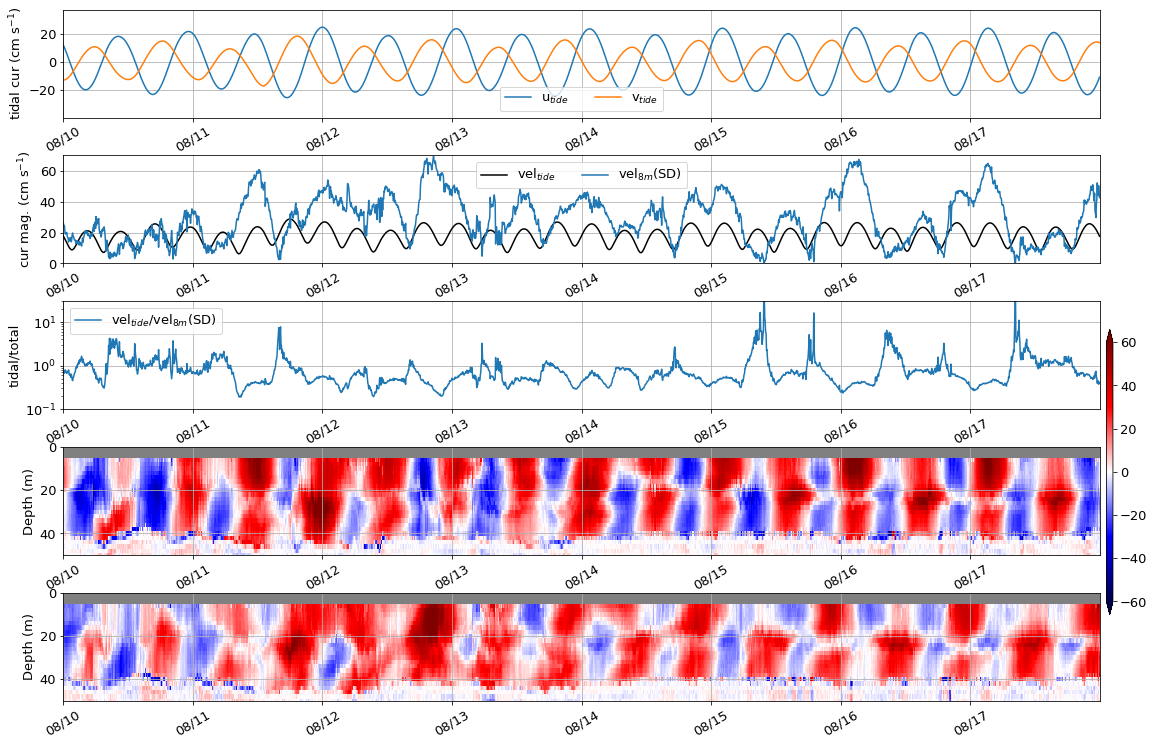

In [20]:
### plot tidal current 
# tlim_plot = [datetime.datetime(int(year),7,15), datetime.datetime(int(year),11,3)]
tlim_plot = [datetime.datetime(int(year),8,10), datetime.datetime(int(year),8,18)]
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
it = np.where( (dtime_cur_SD>= tlim_plot[0]) & (dtime_cur_SD< tlim_plot[1]) )[0]
iz_SD = 1; z_SD = '{:.0f}m'.format(depths_cur_SD[iz_SD])
nrow = 5
ylabels = ['tidal cur (cm s$^{-1}$)','cur mag. (cm s$^{-1}$)','tidal/total','Depth (m)','Depth (m)']
vellim = [-60,60]
cmap = 'seismic'#'PiYG_r'
###
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(18, 12)
plt.rcParams.update({'font.size': 13})
### u_tidal, v_tidal
plt.subplot(nrow,1,1)
plt.plot( dtime_cur_SD, u_tide, label='u$_{tide}$' )
plt.plot( dtime_cur_SD, v_tide, label='v$_{tide}$' )
### tidal current magnitude
plt.subplot(nrow,1,2)
vel_tide_mag = np.sqrt( np.square(u_tide) + np.square(v_tide) )
plt.plot( dtime_cur_SD, vel_tide_mag, label='vel$_{tide}$',color='k' )
vel_SD_mag = np.sqrt( np.square(uCur_SD) + np.square(vCur_SD) )
plt.plot( dtime_cur_SD, vel_SD_mag[:,iz_SD], label='vel$_{'+z_SD+'}$(SD)')
### ratio of tidal current magnitude / total current magnitude
plt.subplot(nrow,1,3)
plt.semilogy( dtime_cur_SD, np.divide(vel_tide_mag,vel_SD_mag[:,iz_SD]),label='vel$_{tide}$/vel$_{'+z_SD+'}$(SD)' )
### u-SD
plt.subplot(nrow,1,4)
cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, uCur_SD.transpose(),label='u',cmap=cmap,vmin=vellim[0],vmax=vellim[1])
cbar_ax = fig.add_axes([.905,.2,.005,.33])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
### v-SD
plt.subplot(nrow,1,5)
cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, vCur_SD.transpose(),label='u',cmap=cmap,vmin=vellim[0],vmax=vellim[1])
### figure settings
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    if i < 3:
        plt.legend(loc='best',ncol=2)
    if i == 1:
        plt.ylim([0,70])
    if i == 2:
        plt.ylim([1e-1,3e1])
    if i > 2:
        plt.ylim([0,50])
        plt.gca().invert_yaxis()
        plt.gca().set_facecolor('gray')
    plt.grid()
    plt.ylabel(ylabels[i])
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
### save to figure
plt.savefig('timeseries_uv-tidal_vs_total_SD'+platf_num+'({:.1f}m)'.format(depths_cur_SD[iz_SD])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

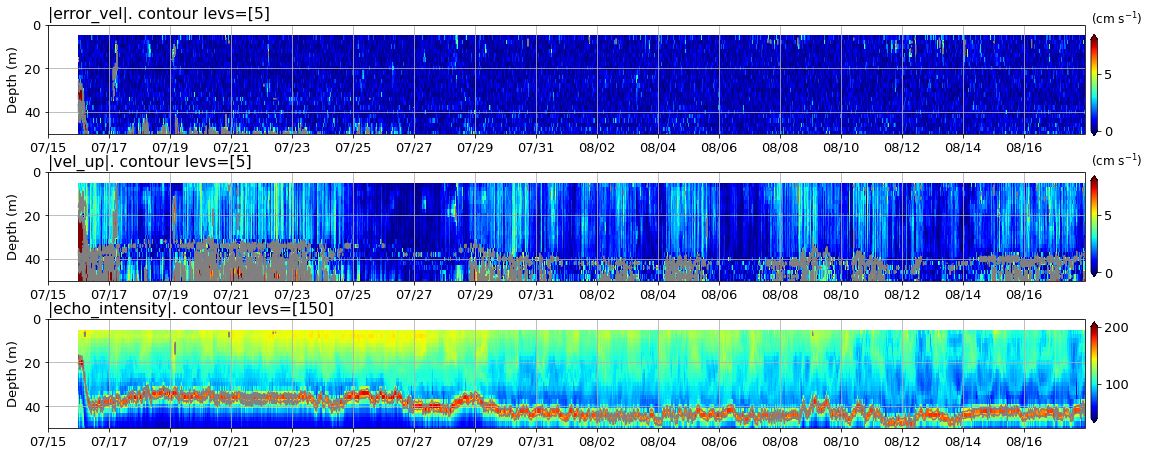

In [7]:
### plot errror velocity & upward velocity
vars_str = ['error_vel','vel_up','echo_intensity']
vars_unit_str = ['(cm s$^{-1}$)','(cm s$^{-1}$)',''] 
vellim = [[0,8],[0,8],[40,200]]
cmap = 'jet'
lev_plot = [[5],[5],[150]]
y0_cb = [0.68,0.4,0.11]
nrow = len(vars_str)
###
plt.clf()
fig, ax = plt.subplots(nrows=nrow)
plt.gcf().set_size_inches(18, 7)
plt.rcParams.update({'font.size': 13})
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    if i < 2:
        var_plot = np.abs(eval(vars_str[i]))
    else:
        var_plot = np.squeeze(eval(vars_str[i])[:,0,:])
    cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, var_plot.transpose(),\
                        label=vars_str[i],cmap=cmap,vmin=vellim[i][0],vmax=vellim[i][1])
    plt.contour(dtime_cur_SD, depths_cur_SD, var_plot.transpose(),linewidths=[1],colors=['gray'],levels=lev_plot[i])    
    ### figure setting
    plt.xticks(tticks[::2],rotation=0)
    plt.gca().set_xticklabels(tticks_label[::2])
    plt.xlim(tlim_plot)
    plt.ylim([0,50])
    plt.gca().invert_yaxis()
    plt.grid()
    plt.ylabel('Depth (m)')
    plt.title('|'+vars_str[i]+'|'+'. contour levs='+str(lev_plot[i]),loc='left')
    ### add colorbar
    cbar_ax = fig.add_axes([.905,y0_cb[i],.005,.2])
    axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
    cbar_ax.set_title(vars_unit_str[i],y=1.1,loc='left',fontsize=12)
###
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)


In [48]:
### compute & plot d(echo_intensity)/dz. echo intensity < -5 counts/ m, or > 100 or < 30 --> consider masking it
# print(ds_adcp)
iOK_echo_intensity = np.ones( echo_intensity.shape, dtype='bool')
iOK_echo_intensity[:,:,:] = True
nbeam = 4
dz = 2
grad_max_detect_bottom = -10
grad_max_shallow_water = -10
z_shallow_water = 20
cri_err_vel = 5
cri_w = 5
test = np.zeros( (len(dtime_cur_SD),) )
for i in range( len(dtime_cur_SD) ):
    for z in range( len(depths_cur_SD)-1 ):
        for j in range( nbeam ):
            if echo_intensity[i,j,z] < 30:
                iOK_echo_intensity[i,j,z] = False
            if echo_intensity[i,j,z] > 150:
                iOK_echo_intensity[i,j,z] = False
            grad_echo = (echo_intensity[i,j,z]-echo_intensity[i,j,z+1])/dz
            if grad_echo< grad_max_shallow_water:
                iOK_echo_intensity[i,j,z] = False
            if (depths_cur_SD[z]> z_shallow_water) & (grad_echo< grad_max_detect_bottom):
                iOK_echo_intensity[i,:,z+1:] = False
                break
        if np.abs(error_vel[i,z])> cri_err_vel:
            iOK_echo_intensity[i,:,z] = False
        if np.abs(vel_up[i,z])> cri_w:
            iOK_echo_intensity[i,:,z] = False

### index of echo_intensity to be used
iOK_echo_intensity_one = np.ones( uCur_SD.shape, dtype='bool')
iOK_echo_intensity_one[:,:] = True
for i in range( len(dtime_cur_SD) ):
    for z in range( len(depths_cur_SD)-1 ):
        if np.sum(iOK_echo_intensity[i,:,z])< nbeam:
            iOK_echo_intensity_one[i,z] = False

<Figure size 432x288 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

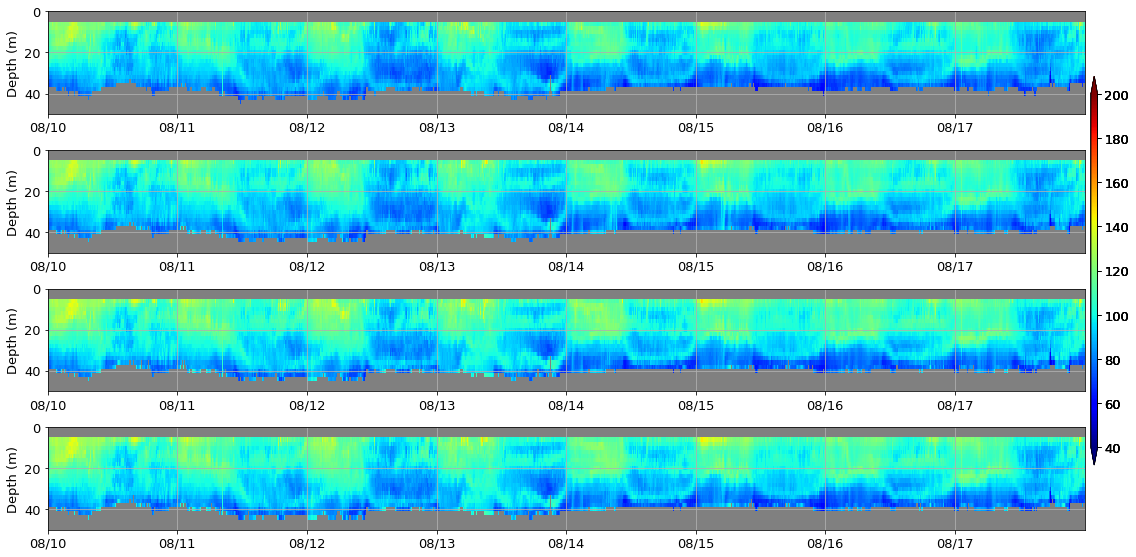

In [38]:
### plot echo intensity - masked out 
### plot errror velocity & upward velocity
tlim_plot = [datetime.datetime(int(year),8,10), datetime.datetime(int(year),8,18)]
vars_unit_str = [''] 
vellim = [40,200]
cmap = 'jet'
lev_plot = [[150]]
nrow = nbeam
###
for p in range( 2 ):
    var_plot = echo_intensity.copy()
    if p == 0:
        str_flag = ''
    elif p == 1:
        var_plot[~iOK_echo_intensity] = np.nan
        str_flag = '(apply-flag)'
    ###
    plt.clf()
    fig, ax = plt.subplots(nrows=nrow)
    plt.gcf().set_size_inches(18, 9)
    plt.rcParams.update({'font.size': 13})
    for i in range( nrow ):
        plt.subplot(nrow,1,i+1)
        cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, var_plot[:,i,:].transpose(),\
                            cmap=cmap,vmin=vellim[0],vmax=vellim[1])
        ### figure setting
        plt.xticks(tticks,rotation=0)
        plt.gca().set_xticklabels(tticks_label)
        plt.xlim(tlim_plot)
        plt.ylim([0,50])
        plt.gca().invert_yaxis()
        plt.grid()
        plt.ylabel('Depth (m)')
        plt.gca().set_facecolor('gray')
        # plt.title('|'+vars_str[i]+'|'+'. contour levs='+str(lev_plot[i]),loc='left')
        ### add colorbar
        cbar_ax = fig.add_axes([.905,0.2,.005,.6])
        axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
        # cbar_ax.set_title(vars_unit_str[i],y=1.1,loc='left',fontsize=12)
    ###
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
    ### save to figure
    plt.savefig('time-depth_echo-int'+str_flag+'_SD'+platf_num+'_'+\
                tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

In [39]:
### print the stats of tidal current magnitudes and ratio of tide/total
vars_str = ['vel_tide_mag','vel_SD_mag[:,iz_SD]']
perc_lim = [10,90]
for i in range( len(vars_str) ):
    y = eval(vars_str[i])[it]
    isOK = ~np.isnan( y )
    mn = np.nanmean( y )
    median = np.nanmedian( y )
    perc = np.percentile( y[isOK],perc_lim )
    print('mean, median, {:.0f}, {:.0f} percentiles of '.format(perc_lim[0],perc_lim[1])+vars_str[i]+\
          '= {:.2f}(cm/s), {:.2f}(cm/s), {:.2f}, {:.2f}'.format(mn, median, perc[0], perc[1]))

mean, median, 10, 90 percentiles of vel_tide_mag= 17.76(cm/s), 18.31(cm/s), 10.03, 25.15
mean, median, 10, 90 percentiles of vel_SD_mag[:,iz_SD]= 29.06(cm/s), 28.40(cm/s), 9.60, 49.16


/Users/chi/opt/anaconda3/envs/newpycode/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


<Figure size 432x288 with 0 Axes>

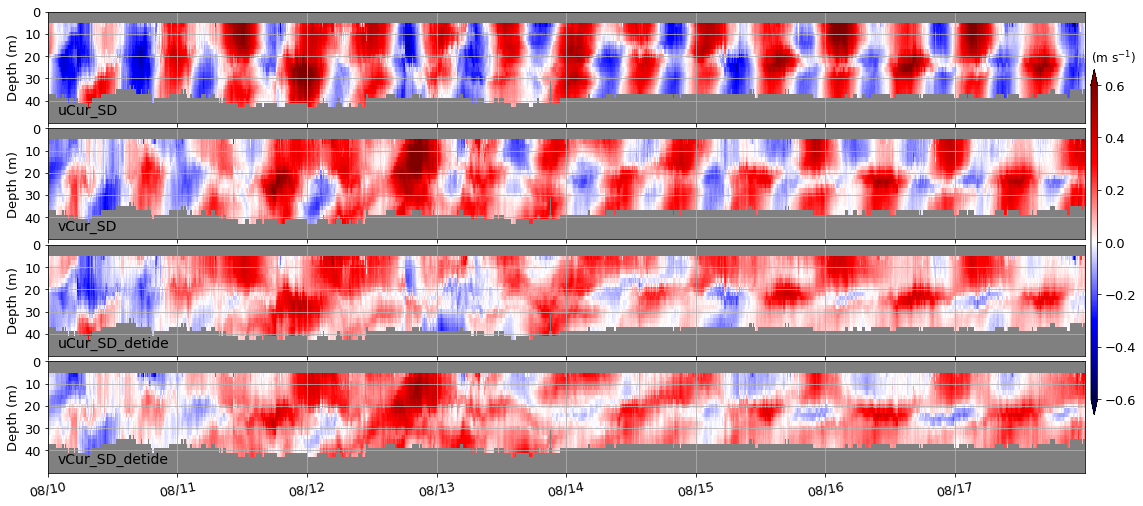

In [44]:
### plot detide current
# tlim_plot = [datetime.datetime(int(year),7,15), datetime.datetime(int(year),11,3)]
tlim_plot = [datetime.datetime(int(year),8,10), datetime.datetime(int(year),8,18)]
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
it = np.where( (dtime_cur_SD>= tlim_plot[0]) & (dtime_cur_SD< tlim_plot[1]) )[0]
iz_SD = 1; z_SD = '{:.0f}m'.format(depths_cur_SD[iz_SD])
vars_str = ['uCur_SD','vCur_SD','uCur_SD_detide','vCur_SD_detide']
nrow = len(vars_str)
ylabels = ['Depth (m)']*nrow
vellim = [-0.6,0.6]
cmap = 'seismic'
### plot
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(18, 8)
plt.rcParams.update({'font.size': 13})
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    y = eval( vars_str[i] ).copy()
    y[~iOK_echo_intensity_one] = np.nan
    cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, 0.01*y.transpose(),cmap=cmap,vmin=vellim[0],vmax=vellim[1])
    ### figure setting
    plt.xticks(tticks,rotation=10)
    if i == nrow-1:
        plt.gca().set_xticklabels(tticks_label)
    else:
        plt.gca().set_xticklabels('')
    plt.xlim(tlim_plot)
    plt.ylim([0,50])
    plt.yticks(np.arange(0,50,10))
    plt.gca().invert_yaxis()
    plt.grid()
    plt.ylabel(ylabels[i])
    plt.gca().text(0.01,0.05,vars_str[i],ha='left',va='bottom',transform=plt.gca().transAxes,fontsize=14)
    plt.gca().set_facecolor('gray')
### add colorbar
cbar_ax = fig.add_axes([.905,.2,.005,.6])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
cbar_ax.set_title('(m s$^{-1}$)',y=1.05,loc='left',fontsize=12)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
### save to figure
plt.savefig('time-depth_uv_vs_detide_SD'+platf_num+'({:.1f}m)'.format(depths_cur_SD[iz_SD])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

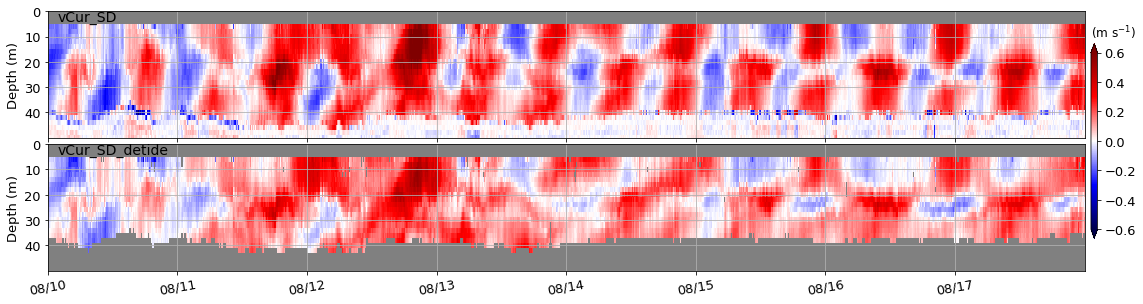

In [52]:
### plot detide current - just u or v. One removed bottom and the other without. 
# tlim_plot = [datetime.datetime(int(year),7,15), datetime.datetime(int(year),11,3)]
tlim_plot = [datetime.datetime(int(year),8,10), datetime.datetime(int(year),8,18)]
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
it = np.where( (dtime_cur_SD>= tlim_plot[0]) & (dtime_cur_SD< tlim_plot[1]) )[0]
iz_SD = 1; z_SD = '{:.0f}m'.format(depths_cur_SD[iz_SD])
vars_str = ['vCur_SD','vCur_SD_detide']
nrow = len(vars_str)
ylabels = ['Depth (m)']*nrow
vellim = [-0.6,0.6]
cmap = 'seismic'
### plot
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(18, 4.5)
plt.rcParams.update({'font.size': 13})
for i, varnm in enumerate( vars_str ):
    plt.subplot(nrow,1,i+1)
    y = eval( varnm ).copy()
    if 'detide' in varnm:
        y[~iOK_echo_intensity_one] = np.nan
    cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, 0.01*y.transpose(),cmap=cmap,vmin=vellim[0],vmax=vellim[1])
    ### figure setting
    plt.xticks(tticks,rotation=10)
    if i == nrow-1:
        plt.gca().set_xticklabels(tticks_label)
    else:
        plt.gca().set_xticklabels('')
    plt.xlim(tlim_plot)
    plt.ylim([0,50])
    plt.yticks(np.arange(0,50,10))
    plt.gca().invert_yaxis()
    plt.grid()
    plt.ylabel(ylabels[i])
    plt.gca().text(0.01,0.9,varnm,ha='left',va='bottom',transform=plt.gca().transAxes,fontsize=14)
    plt.gca().set_facecolor('gray')
### add colorbar
cbar_ax = fig.add_axes([.905,.2,.005,.6])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
cbar_ax.set_title('(m s$^{-1}$)',y=1.05,loc='left',fontsize=12)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
### save to figure
plt.savefig('time-depth_v_vs_detide_SD'+platf_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')